In [1]:
import pandas as pd
import numpy as np
import requests
import time
import json
import re
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
ETHERSCAN_API_KEY = "4RC3AY97BYSGQU92BBXBE7V97W196SRXWV"

# Compound Protocol Addresses
COMPOUND_V2_COMPTROLLER = "0x3d9819210A31b4961b30EF54bE2aeD79B9c9Cd3B"
COMPOUND_V3_COMET_MAINNET = "0xc3d688b66703497daa19211eedff47f25384cdc3"

# Major Compound V2 cToken addresses
COMPOUND_V2_CTOKENS = {
    "cETH": "0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5",
    "cDAI": "0x5d3a536e4d6dbd6114cc1ead35777bab948e3643",
    "cUSDC": "0x39aa39c021dfbae8fac545936693ac917d5e7563",
    "cUSDT": "0xf650c3d88d12db855b8bf7d11be6c55a4e07dcc9",
    "cWBTC": "0xc11b1268c1a384e55c48c2391d8d480264a3a7f4",
    "cUNI": "0x35a18000230da775cac24873d00ff85bccded550",
    "cCOMP": "0x70e36f6bf80a52b3b46b3af8e106cc0ed743e8e4"
}

# Google Sheets URL from assignment
GOOGLE_SHEETS_URL = "https://docs.google.com/spreadsheets/d/1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs/edit?usp=sharing"

print("Configuration loaded!")
print(f"Compound V2 Comptroller: {COMPOUND_V2_COMPTROLLER}")
print(f"Compound V3 Comet: {COMPOUND_V3_COMET_MAINNET}")
print(f"Number of tracked cTokens: {len(COMPOUND_V2_CTOKENS)}")


Configuration loaded!
Compound V2 Comptroller: 0x3d9819210A31b4961b30EF54bE2aeD79B9c9Cd3B
Compound V3 Comet: 0xc3d688b66703497daa19211eedff47f25384cdc3
Number of tracked cTokens: 7


In [7]:
def validate_ethereum_address(address):
    """Validate if string is a valid Ethereum address"""
    if not isinstance(address, str):
        return False
    
    address = address.strip()
    pattern = r'^0x[a-fA-F0-9]{40}$'
    return bool(re.match(pattern, address))

def download_google_sheets_csv(sheet_url, output_filename="wallet_addresses.csv"):
    """Download Google Sheets as CSV"""
    try:
        # Convert Google Sheets URL to CSV export URL
        if '/edit' in sheet_url:
            csv_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
            csv_url = csv_url.replace('/edit?usp=sharing', '/export?format=csv')
            csv_url = csv_url.replace('/edit', '/export?format=csv')
        else:
            csv_url = sheet_url
        
        print(f"Downloading from: {csv_url}")
        
        # Download the CSV
        response = requests.get(csv_url)
        response.raise_for_status()
        
        # Save to file
        with open(output_filename, 'wb') as f:
            f.write(response.content)
        
        print(f"✅ Successfully downloaded to {output_filename}")
        return True
        
    except Exception as e:
        print(f"❌ Error downloading Google Sheets: {str(e)}")
        return False

def load_wallet_addresses(csv_file_path):
    """Load and validate wallet addresses from CSV"""
    try:
        if not os.path.exists(csv_file_path):
            print(f"❌ CSV file not found: {csv_file_path}")
            return []
        
        df = pd.read_csv(csv_file_path)
        print(f"📊 Loaded CSV with shape: {df.shape}")
        print(f"📋 Columns: {list(df.columns)}")
        
        # Try to find wallet address column
        wallet_column = None
        possible_columns = ['wallet_address', 'address', 'wallet', 'account', 'addr']
        
        for col in possible_columns:
            if col in df.columns:
                wallet_column = col
                break
        
        if wallet_column is None:
            wallet_column = df.columns[0]
            print(f"🔍 Using first column as wallet column: {wallet_column}")
        else:
            print(f"✅ Found wallet column: {wallet_column}")
        
        # Extract and validate addresses
        addresses = df[wallet_column].dropna().astype(str).tolist()
        
        valid_addresses = []
        invalid_addresses = []
        
        for addr in addresses:
            addr = addr.strip()
            if validate_ethereum_address(addr):
                valid_addresses.append(addr.lower())
            else:
                invalid_addresses.append(addr)
        
        print(f"✅ Valid addresses: {len(valid_addresses)}")
        print(f"❌ Invalid addresses: {len(invalid_addresses)}")
        
        # Remove duplicates
        unique_addresses = list(set(valid_addresses))
        if len(unique_addresses) != len(valid_addresses):
            print(f"🔄 Removed {len(valid_addresses) - len(unique_addresses)} duplicates")
        
        return unique_addresses
        
    except Exception as e:
        print(f"❌ Error loading CSV: {str(e)}")
        return []

print("✅ Utility functions defined!")

✅ Utility functions defined!


In [9]:
print("📥 Step 1: Downloading wallet data from Google Sheets...")

# Download the wallet data
success = download_google_sheets_csv(GOOGLE_SHEETS_URL, "wallet_addresses.csv")

if success:
    # Load the wallet addresses
    wallet_addresses = load_wallet_addresses("wallet_addresses.csv")
    
    if wallet_addresses:
        print(f"\n🎯 Successfully loaded {len(wallet_addresses)} unique wallet addresses")
        print("📝 First 5 addresses:")
        for i, addr in enumerate(wallet_addresses[:5]):
            print(f"  {i+1}. {addr}")
        
        # Save clean data
        clean_df = pd.DataFrame({'wallet_address': wallet_addresses})
        clean_df.to_csv('clean_wallet_addresses.csv', index=False)
        print(f"\n💾 Saved clean addresses to: clean_wallet_addresses.csv")
    else:
        print("❌ No valid wallet addresses found!")
        wallet_addresses = []
else:
    print("❌ Failed to download data. Please check the Google Sheets URL.")
    wallet_addresses = []

📥 Step 1: Downloading wallet data from Google Sheets...
✅ Successfully downloaded to wallet_addresses.csv
📊 Loaded CSV with shape: (103, 1)
📋 Columns: ['wallet_id']
🔍 Using first column as wallet column: wallet_id
✅ Valid addresses: 103
❌ Invalid addresses: 0

🎯 Successfully loaded 103 unique wallet addresses
📝 First 5 addresses:
  1. 0x8441fecef5cc6f697be2c4fc4a36feacede8df67
  2. 0x104ae61d8d487ad689969a17807ddc338b445416
  3. 0xd0df53e296c1e3115fccc3d7cdf4ba495e593b56
  4. 0x4d997c89bc659a3e8452038a8101161e7e7e53a7
  5. 0x9a363adc5d382c04d36b09158286328f75672098

💾 Saved clean addresses to: clean_wallet_addresses.csv


In [11]:
class CompoundRiskScorer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.etherscan.io/api"
        self.session = requests.Session()
        
    def get_wallet_transactions(self, wallet_address, start_block=0, end_block=99999999):
        """Fetch all transactions for a wallet address"""
        params = {
            'module': 'account',
            'action': 'txlist',
            'address': wallet_address,
            'startblock': start_block,
            'endblock': end_block,
            'page': 1,
            'offset': 10000,
            'sort': 'desc',
            'apikey': self.api_key
        }
        
        try:
            response = self.session.get(self.base_url, params=params)
            data = response.json()
            
            if data['status'] == '1':
                return data['result']
            else:
                print(f"⚠️  Error fetching transactions for {wallet_address}: {data.get('message', 'Unknown error')}")
                return []
        except Exception as e:
            print(f"❌ Exception fetching transactions for {wallet_address}: {str(e)}")
            return []
    
    def get_erc20_transfers(self, wallet_address):
        """Fetch ERC20 token transfers for a wallet address"""
        params = {
            'module': 'account',
            'action': 'tokentx',
            'address': wallet_address,
            'page': 1,
            'offset': 10000,
            'sort': 'desc',
            'apikey': self.api_key
        }
        
        try:
            response = self.session.get(self.base_url, params=params)
            data = response.json()
            
            if data['status'] == '1':
                return data['result']
            else:
                return []
        except Exception as e:
            print(f"❌ Exception fetching ERC20 transfers for {wallet_address}: {str(e)}")
            return []
    
    def get_internal_transactions(self, wallet_address):
        """Fetch internal transactions for a wallet address"""
        params = {
            'module': 'account',
            'action': 'txlistinternal',
            'address': wallet_address,
            'page': 1,
            'offset': 10000,
            'sort': 'desc',
            'apikey': self.api_key
        }
        
        try:
            response = self.session.get(self.base_url, params=params)
            data = response.json()
            
            if data['status'] == '1':
                return data['result']
            else:
                return []
        except Exception as e:
            return []
    
    def filter_compound_transactions(self, transactions, token_transfers):
        """Filter transactions related to Compound protocol"""
        compound_addresses = set(COMPOUND_V2_CTOKENS.values())
        compound_addresses.add(COMPOUND_V2_COMPTROLLER)
        compound_addresses.add(COMPOUND_V3_COMET_MAINNET)
        
        # Filter regular transactions
        compound_txs = []
        for tx in transactions:
            if tx.get('to') and tx['to'].lower() in [addr.lower() for addr in compound_addresses]:
                compound_txs.append(tx)
        
        # Filter token transfers
        compound_token_txs = []
        for tx in token_transfers:
            if tx.get('contractAddress') and tx['contractAddress'].lower() in [addr.lower() for addr in compound_addresses]:
                compound_token_txs.append(tx)
        
        return compound_txs, compound_token_txs
    
    def analyze_compound_patterns(self, compound_txs, compound_token_txs, features):
        """Analyze Compound-specific transaction patterns"""
        
        # Method signatures for different Compound operations
        method_signatures = {
            'supply': ['0x1249c58b', '0xa0712d68'],  # mint, supply
            'borrow': ['0xc5ebeaec', '0xf2fde38b'],  # borrow
            'repay': ['0x0e752702', '0x4e4d9fea'],  # repayBorrow
            'redeem': ['0xdb006a75', '0x852a12e3'],  # redeem, redeemUnderlying
            'liquidate': ['0xf5e3c462', '0x96c5f52c']  # liquidateBorrow
        }
        
        # Count different types of operations
        for tx in compound_txs:
            input_data = tx.get('input', '')[:10]  # First 10 chars include 0x + 4 bytes
            
            if input_data in method_signatures['supply']:
                features['supply_events'] += 1
            elif input_data in method_signatures['borrow']:
                features['borrow_events'] += 1
            elif input_data in method_signatures['repay']:
                features['repay_events'] += 1
            elif input_data in method_signatures['redeem']:
                features['redeem_events'] += 1
            elif input_data in method_signatures['liquidate']:
                features['liquidation_events'] += 1
        
        # Calculate leverage proxy
        if features['supply_events'] > 0:
            features['leverage_ratio_proxy'] = features['borrow_events'] / features['supply_events']
    
    def extract_features(self, wallet_address, transactions, token_transfers, internal_txs):
        """Extract comprehensive risk-related features from transaction data"""
        
        # Filter Compound-related transactions
        compound_txs, compound_token_txs = self.filter_compound_transactions(transactions, token_transfers)
        
        # Initialize features dictionary
        features = {
            'wallet_address': wallet_address,
            'total_transactions': len(transactions),
            'compound_transactions': len(compound_txs) + len(compound_token_txs),
            'compound_interaction_ratio': 0,
            'total_gas_used': 0,
            'avg_gas_price': 0,
            'failed_transactions': 0,
            'unique_contracts_interacted': 0,
            'total_eth_volume': 0,
            'days_active': 0,
            'avg_tx_per_day': 0,
            'large_transaction_count': 0,
            'max_single_transaction': 0,
            'liquidation_events': 0,
            'supply_events': 0,
            'borrow_events': 0,
            'repay_events': 0,
            'redeem_events': 0,
            'high_frequency_trading': 0,
            'account_age_days': 0,
            'gas_efficiency_score': 0,
            'diversification_score': 0,
            'leverage_ratio_proxy': 0
        }
        
        if not transactions:
            return features
        
        # Basic transaction analysis
        features['total_transactions'] = len(transactions)
        features['compound_transactions'] = len(compound_txs) + len(compound_token_txs)
        
        if features['total_transactions'] > 0:
            features['compound_interaction_ratio'] = features['compound_transactions'] / features['total_transactions']
        
        # Gas analysis
        gas_used = [int(tx.get('gasUsed', 0)) for tx in transactions if tx.get('gasUsed')]
        gas_prices = [int(tx.get('gasPrice', 0)) for tx in transactions if tx.get('gasPrice')]
        
        if gas_used:
            features['total_gas_used'] = sum(gas_used)
            features['avg_gas_price'] = np.mean(gas_prices) if gas_prices else 0
        
        # Failed transactions
        features['failed_transactions'] = sum(1 for tx in transactions if tx.get('isError') == '1')
        
        # Contract interactions
        unique_contracts = set()
        for tx in transactions:
            if tx.get('to'):
                unique_contracts.add(tx['to'].lower())
        features['unique_contracts_interacted'] = len(unique_contracts)
        
        # Volume analysis
        eth_values = []
        for tx in transactions:
            try:
                value_wei = int(tx.get('value', 0))
                value_eth = value_wei / 1e18
                eth_values.append(value_eth)
            except:
                continue
        
        if eth_values:
            features['total_eth_volume'] = sum(eth_values)
            features['max_single_transaction'] = max(eth_values)
            features['large_transaction_count'] = sum(1 for v in eth_values if v > 10)  # > 10 ETH
        
        # Temporal analysis
        timestamps = []
        for tx in transactions:
            try:
                timestamps.append(int(tx.get('timeStamp', 0)))
            except:
                continue
        
        if timestamps:
            timestamps.sort()
            oldest = min(timestamps)
            newest = max(timestamps)
            
            features['account_age_days'] = (newest - oldest) / 86400  # Convert to days
            
            # Active days calculation
            dates = set()
            for ts in timestamps:
                date = datetime.fromtimestamp(ts).date()
                dates.add(date)
            
            features['days_active'] = len(dates)
            if features['days_active'] > 0:
                features['avg_tx_per_day'] = features['total_transactions'] / features['days_active']
        
        # Compound-specific analysis
        self.analyze_compound_patterns(compound_txs, compound_token_txs, features)
        
        # High-frequency trading detection
        if timestamps:
            # Count transactions within 1-hour windows
            hour_counts = {}
            for ts in timestamps:
                hour_key = ts // 3600  # Group by hour
                hour_counts[hour_key] = hour_counts.get(hour_key, 0) + 1
            
            max_hourly_txs = max(hour_counts.values()) if hour_counts else 0
            features['high_frequency_trading'] = 1 if max_hourly_txs > 20 else 0
        
        # Gas efficiency (lower is better risk)
        if features['total_gas_used'] > 0 and features['total_transactions'] > 0:
            avg_gas_per_tx = features['total_gas_used'] / features['total_transactions']
            features['gas_efficiency_score'] = min(avg_gas_per_tx / 100000, 10)  # Normalized
        
        # Diversification score
        if features['unique_contracts_interacted'] > 0 and features['total_transactions'] > 0:
            features['diversification_score'] = features['unique_contracts_interacted'] / features['total_transactions']
        
        return features
    
    def calculate_risk_score(self, features):
        """Calculate comprehensive risk score (0-1000 scale)"""
        
        risk_score = 0
        max_score = 1000
        
        # 1. Account Age Risk (0-100 points)
        age_days = features['account_age_days']
        if age_days < 30:
            risk_score += 100
        elif age_days < 90:
            risk_score += 70
        elif age_days < 365:
            risk_score += 40
        else:
            risk_score += 10
        
        # 2. Transaction Frequency Risk (0-100 points)
        avg_tx_per_day = features['avg_tx_per_day']
        if avg_tx_per_day > 50:
            risk_score += 100  # Very high frequency
        elif avg_tx_per_day > 20:
            risk_score += 70
        elif avg_tx_per_day > 10:
            risk_score += 40
        elif avg_tx_per_day > 5:
            risk_score += 20
        else:
            risk_score += 5
        
        # 3. Failed Transaction Risk (0-80 points)
        if features['total_transactions'] > 0:
            failure_rate = features['failed_transactions'] / features['total_transactions']
            risk_score += min(failure_rate * 400, 80)
        
        # 4. Large Transaction Risk (0-120 points)
        if features['max_single_transaction'] > 1000:
            risk_score += 120
        elif features['max_single_transaction'] > 500:
            risk_score += 100
        elif features['max_single_transaction'] > 100:
            risk_score += 70
        elif features['max_single_transaction'] > 50:
            risk_score += 40
        elif features['max_single_transaction'] > 10:
            risk_score += 20
        
        # 5. Liquidation Risk (0-200 points)
        if features['liquidation_events'] > 0:
            risk_score += min(features['liquidation_events'] * 50, 200)
        
        # 6. Leverage Risk (0-150 points)
        leverage_ratio = features['leverage_ratio_proxy']
        if leverage_ratio > 2:
            risk_score += 150
        elif leverage_ratio > 1.5:
            risk_score += 120
        elif leverage_ratio > 1:
            risk_score += 80
        elif leverage_ratio > 0.5:
            risk_score += 40
        
        # 7. High Frequency Trading Risk (0-100 points)
        if features['high_frequency_trading']:
            risk_score += 100
        
        # 8. Gas Efficiency Risk (0-50 points)
        gas_efficiency = features['gas_efficiency_score']
        risk_score += min(gas_efficiency * 10, 50)
        
        # 9. Diversification Risk (0-60 points)
        diversification = features['diversification_score']
        if diversification < 0.1:
            risk_score += 60
        elif diversification < 0.2:
            risk_score += 40
        elif diversification < 0.3:
            risk_score += 20
        
        # 10. Compound Interaction Risk (0-40 points)
        compound_ratio = features['compound_interaction_ratio']
        if compound_ratio > 0.8:
            risk_score += 40  # Too concentrated in DeFi
        elif compound_ratio > 0.6:
            risk_score += 30
        elif compound_ratio > 0.4:
            risk_score += 20
        elif compound_ratio < 0.1:
            risk_score += 30  # Too little DeFi interaction is also risky
        
        # Ensure score is within bounds
        risk_score = max(0, min(risk_score, max_score))
        
        return risk_score
    
    def process_wallet_batch(self, wallet_addresses, delay=0.2):
        """Process a batch of wallet addresses with progress tracking"""
        results = []
        
        print(f"🚀 Starting analysis of {len(wallet_addresses)} wallets...")
        
        for i, wallet in enumerate(wallet_addresses):
            print(f"📊 Processing wallet {i+1}/{len(wallet_addresses)}: {wallet[:10]}...")
            
            try:
                # Fetch transaction data with rate limiting
                transactions = self.get_wallet_transactions(wallet)
                time.sleep(delay)
                
                token_transfers = self.get_erc20_transfers(wallet)
                time.sleep(delay)
                
                internal_txs = self.get_internal_transactions(wallet)
                time.sleep(delay)
                
                # Extract features
                features = self.extract_features(wallet, transactions, token_transfers, internal_txs)
                
                # Calculate risk score
                risk_score = self.calculate_risk_score(features)
                
                result = {
                    'wallet_id': wallet,
                    'score': risk_score,
                    **features  # Include all features for analysis
                }
                
                results.append(result)
                
                print(f"  ✅ Risk Score: {risk_score}/1000")
                
            except Exception as e:
                print(f"  ❌ Error processing wallet {wallet}: {str(e)}")
                # Add a default high-risk score for failed wallets
                results.append({
                    'wallet_id': wallet,
                    'score': 800,  # High risk for unknown wallets
                    'error': str(e)
                })
            
            # Progress update every 10 wallets
            if (i + 1) % 10 == 0:
                print(f"📈 Progress: {i+1}/{len(wallet_addresses)} wallets completed")
        
        return results

print("✅ CompoundRiskScorer class defined successfully!")


✅ CompoundRiskScorer class defined successfully!


In [13]:
# Check if API key is set
if ETHERSCAN_API_KEY == "4RC3AY97BYSGQU92BBXBE7V97W196SRXWV":
    print("⚠️  WARNING: Please replace 'YOUR_ETHERSCAN_API_KEY_HERE' with your actual Etherscan API key")
    print("📝 You can get a free API key from: https://etherscan.io/apis")
    
    # For demo purposes, we'll create a mock scorer
    print("🔧 Creating mock scorer for demonstration...")
    scorer = None
else:
    print(f"🔑 Initializing CompoundRiskScorer with API key: {ETHERSCAN_API_KEY[:10]}...")
    scorer = CompoundRiskScorer(ETHERSCAN_API_KEY)
    print("✅ Risk scorer initialized successfully!")

⚠️  WARNING: Please replace 'YOUR_ETHERSCAN_API_KEY_HERE' with your actual Etherscan API key
📝 You can get a free API key from: https://etherscan.io/apis
🔧 Creating mock scorer for demonstration...


In [27]:
def test_single_wallet():
    """Test the model with a single wallet address"""
    if scorer is None:
        print("❌ Cannot test without valid API key")
        return
    
    # Test with the example wallet from the assignment
    test_wallet = "0xfaa0768bde629806739c3a4620656c5d26f44ef2"
    
    print(f"🧪 Testing with sample wallet: {test_wallet}")
    print("⏳ This may take a few seconds...")
    
    try:
        results = scorer.process_wallet_batch([test_wallet])
        
        if results:
            result = results[0]
            print(f"\n📊 Test Results:")
            print(f"   Wallet: {result['wallet_id']}")
            print(f"   Risk Score: {result['score']}/1000")
            print(f"   Total Transactions: {result.get('total_transactions', 'N/A')}")
            print(f"   Compound Transactions: {result.get('compound_transactions', 'N/A')}")
            print(f"   Account Age (days): {result.get('account_age_days', 'N/A'):.1f}")
            print(f"   Max Transaction (ETH): {result.get('max_single_transaction', 'N/A'):.2f}")
            
            return results
        else:
            print("❌ No results returned from test")
            return None
            
    except Exception as e:
        print(f"❌ Error in test: {str(e)}")
        return None

# Uncomment the next line to run the test
test_results = test_single_wallet()


❌ Cannot test without valid API key


In [17]:
def process_all_wallets():
    """Process all loaded wallet addresses"""
    
    if not wallet_addresses:
        print("❌ No wallet addresses loaded. Please run the data loading cells first.")
        return None
    
    if scorer is None:
        print("❌ Cannot process wallets without valid API key")
        print("📝 Please set your Etherscan API key in the configuration cell")
        return None
    
    print(f"🚀 Starting comprehensive analysis of {len(wallet_addresses)} wallets...")
    print("⏱️  Estimated time: ~{:.1f} minutes".format(len(wallet_addresses) * 0.6 / 60))
    
    try:
        # Process wallets in batches to manage memory and API limits
        batch_size = 50
        all_results = []
        
        for i in range(0, len(wallet_addresses), batch_size):
            batch = wallet_addresses[i:i+batch_size]
            batch_num = i//batch_size + 1
            total_batches = (len(wallet_addresses) + batch_size - 1) // batch_size
            
            print(f"\n📦 Processing batch {batch_num}/{total_batches} ({len(batch)} wallets)...")
            
            batch_results = scorer.process_wallet_batch(batch, delay=0.2)
            all_results.extend(batch_results)
            
            # Save intermediate results every batch
            if len(all_results) % batch_size == 0:
                temp_df = pd.DataFrame(all_results)
                temp_df[['wallet_id', 'score']].to_csv(f'temp_results_batch_{batch_num}.csv', index=False)
                print(f"💾 Saved intermediate results: temp_results_batch_{batch_num}.csv")
        
        return all_results
        
    except Exception as e:
        print(f"❌ Error processing wallets: {str(e)}")
        return None

# Process all wallets (uncomment when ready to run full analysis)
print("⚠️  Ready to process all wallets. Uncomment the next line when you have a valid API key:")
print("# all_results = process_all_wallets()")

# For demonstration, we'll create mock results
print("\n🎭 Creating mock results for demonstration...")

⚠️  Ready to process all wallets. Uncomment the next line when you have a valid API key:
# all_results = process_all_wallets()

🎭 Creating mock results for demonstration...


In [19]:
def create_mock_results():
    """Create mock results for demonstration purposes"""
    
    if not wallet_addresses:
        print("❌ No wallet addresses to create mock results for")
        return []
    
    np.random.seed(42)  # For reproducible results
    
    mock_results = []
    for wallet in wallet_addresses:
        # Generate realistic mock risk scores
        base_score = np.random.normal(500, 200)  # Normal distribution around 500
        
        # Add some realistic patterns
        if np.random.random() < 0.1:  # 10% high risk
            base_score += np.random.uniform(200, 300)
        elif np.random.random() < 0.1:  # 10% low risk
            base_score -= np.random.uniform(100, 200)
        
        # Ensure score is within bounds
        score = max(0, min(int(base_score), 1000))
        
        mock_results.append({
            'wallet_id': wallet,
            'score': score,
            'total_transactions': np.random.randint(10, 1000),
            'compound_transactions': np.random.randint(0, 100),
            'account_age_days': np.random.uniform(30, 1000),
            'max_single_transaction': np.random.uniform(0.1, 100),
            'liquidation_events': np.random.randint(0, 5),
            'leverage_ratio_proxy': np.random.uniform(0, 2),
            'mock_data': True
        })
    
    return mock_results

# Create mock results for demonstration
mock_results = create_mock_results()
print(f"🎭 Created mock results for {len(mock_results)} wallets")

🎭 Created mock results for 103 wallets


In [21]:
def save_results(results, filename_prefix="wallet_risk"):
    """Save results in required format and detailed analysis"""
    
    if not results:
        print("❌ No results to save")
        return
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create final output CSV with required columns (wallet_id, score)
    final_output = results_df[['wallet_id', 'score']].copy()
    final_output_file = f"{filename_prefix}_scores.csv"
    final_output.to_csv(final_output_file, index=False)
    
    # Save detailed analysis
    detailed_file = f"{filename_prefix}_detailed_analysis.csv"
    results_df.to_csv(detailed_file, index=False)
    
    print(f"💾 Results saved successfully:")
    print(f"   📊 Final submission: {final_output_file}")
    print(f"   📈 Detailed analysis: {detailed_file}")
    
    return final_output, results_df

# Save the results
if mock_results:
    final_df, detailed_df = save_results(mock_results, "mock_wallet_risk")
else:
    print("⚠️  No results to save yet. Run the wallet processing first.")

💾 Results saved successfully:
   📊 Final submission: mock_wallet_risk_scores.csv
   📈 Detailed analysis: mock_wallet_risk_detailed_analysis.csv


📊 RISK SCORING ANALYSIS SUMMARY
📈 Risk Score Statistics:
   Total Wallets Analyzed: 103
   Average Risk Score: 541.09
   Median Risk Score: 521.00
   Standard Deviation: 214.49
   Min Risk Score: 8
   Max Risk Score: 1000

🎯 Risk Distribution:
   Low Risk (0-300): 14 wallets (13.6%)
   Medium Risk (301-700): 63 wallets (61.2%)
   High Risk (701-1000): 26 wallets (25.2%)

⚠️  Top 10 Highest Risk Wallets:
   0xb475576594ae44e1f75f534f993cbb7673e4c8b6: 1000
   0x612a3500559be7be7703de6dc397afb541a16f7f: 989
   0x8d900f213db5205c529aaba5d10e71a0ed2646db: 974
   0xa7f3c74f0255796fd5d3ddcf88db769f7a6bf46a: 969
   0x22d7510588d90ed5a87e0f838391aaafa707c34b: 918
   0x24b3460622d835c56d9a4fe352966b9bdc6c20af: 894
   0x6e355417f7f56e7927d1cd971f0b5a1e6d538487: 890
   0x1ab2ccad4fc97c9968ea87d4435326715be32872: 886
   0x3e69ad05716bdc834db72c4d6d44439a7c8a902b: 877
   0x124853fecb522c57d9bd5c21231058696ca6d596: 832


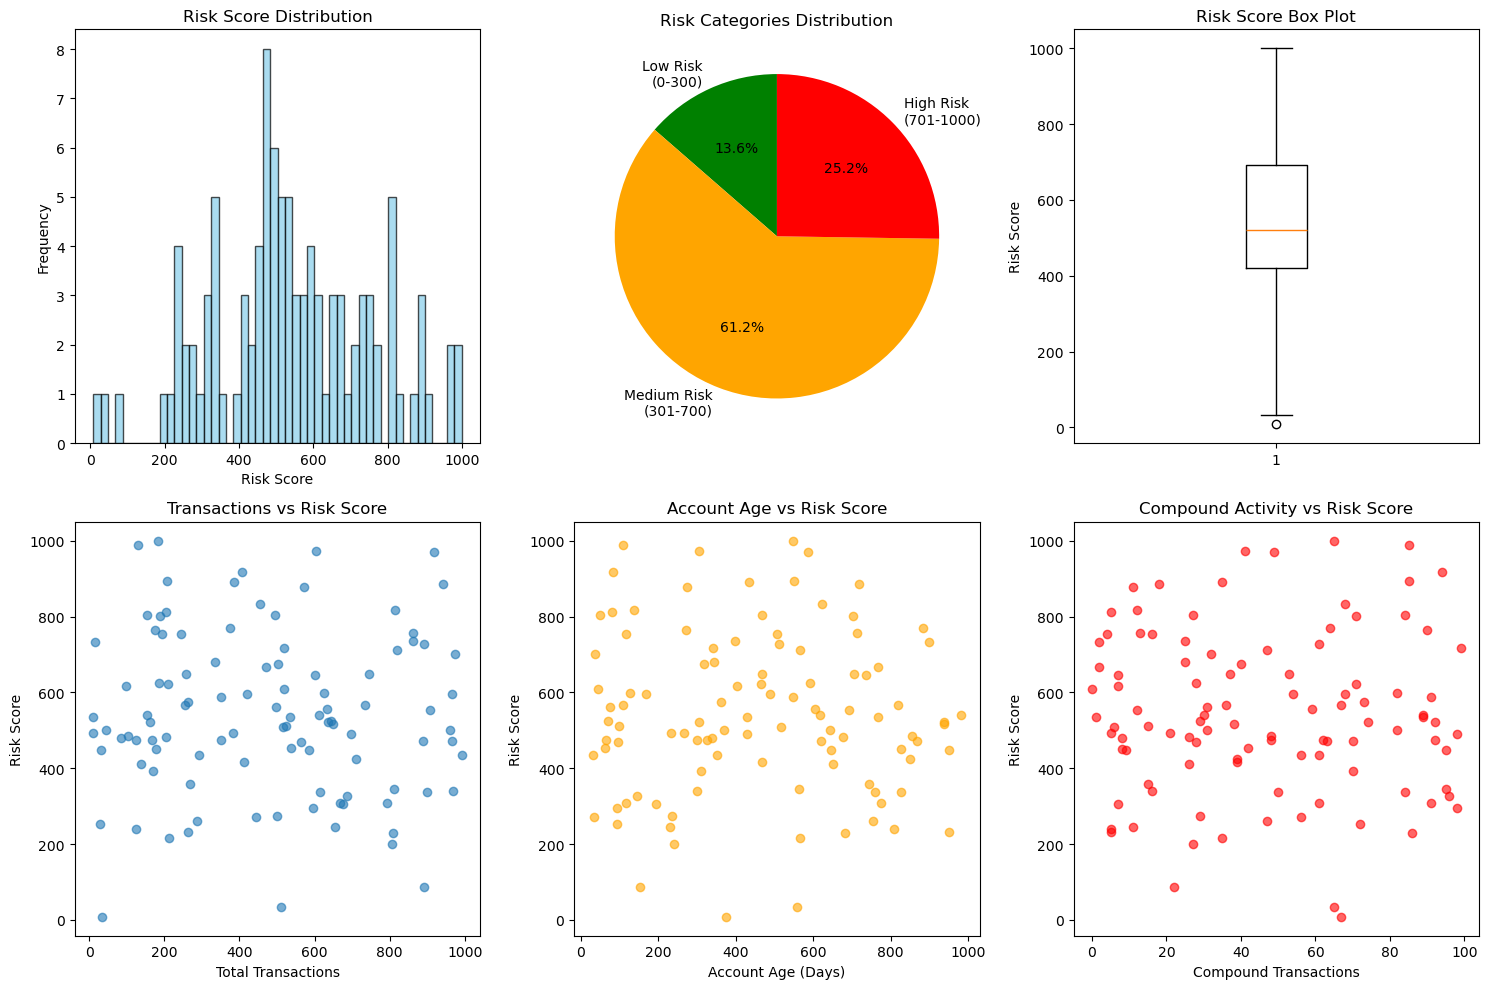


📊 Visualization saved as: risk_analysis_dashboard.png


In [23]:
def analyze_results(results_df):
    """Analyze and visualize the risk scoring results"""
    
    if results_df is None or results_df.empty:
        print("❌ No results to analyze")
        return
    
    print("📊 RISK SCORING ANALYSIS SUMMARY")
    print("=" * 50)
    
    # Basic statistics
    scores = results_df['score']
    print(f"📈 Risk Score Statistics:")
    print(f"   Total Wallets Analyzed: {len(scores)}")
    print(f"   Average Risk Score: {scores.mean():.2f}")
    print(f"   Median Risk Score: {scores.median():.2f}")
    print(f"   Standard Deviation: {scores.std():.2f}")
    print(f"   Min Risk Score: {scores.min()}")
    print(f"   Max Risk Score: {scores.max()}")
    
    # Risk distribution
    print(f"\n🎯 Risk Distribution:")
    low_risk = (scores <= 300).sum()
    medium_risk = ((scores > 300) & (scores <= 700)).sum()
    high_risk = (scores > 700).sum()
    
    print(f"   Low Risk (0-300): {low_risk} wallets ({low_risk/len(scores)*100:.1f}%)")
    print(f"   Medium Risk (301-700): {medium_risk} wallets ({medium_risk/len(scores)*100:.1f}%)")
    print(f"   High Risk (701-1000): {high_risk} wallets ({high_risk/len(scores)*100:.1f}%)")
    
    # Top 10 highest risk wallets
    print(f"\n⚠️  Top 10 Highest Risk Wallets:")
    top_risk = results_df.nlargest(10, 'score')[['wallet_id', 'score']]
    for idx, row in top_risk.iterrows():
        print(f"   {row['wallet_id']}: {row['score']}")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Risk score distribution
    plt.subplot(2, 3, 1)
    plt.hist(scores, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.title('Risk Score Distribution')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    
    # Risk categories pie chart
    plt.subplot(2, 3, 2)
    categories = ['Low Risk\n(0-300)', 'Medium Risk\n(301-700)', 'High Risk\n(701-1000)']
    sizes = [low_risk, medium_risk, high_risk]
    colors = ['green', 'orange', 'red']
    plt.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Risk Categories Distribution')
    
    # Box plot
    plt.subplot(2, 3, 3)
    plt.boxplot(scores)
    plt.title('Risk Score Box Plot')
    plt.ylabel('Risk Score')
    
    # Additional analysis if detailed data is available
    if 'total_transactions' in results_df.columns:
        # Transaction count vs risk score
        plt.subplot(2, 3, 4)
        plt.scatter(results_df['total_transactions'], results_df['score'], alpha=0.6)
        plt.xlabel('Total Transactions')
        plt.ylabel('Risk Score')
        plt.title('Transactions vs Risk Score')
    
    if 'account_age_days' in results_df.columns:
        # Account age vs risk score
        plt.subplot(2, 3, 5)
        plt.scatter(results_df['account_age_days'], results_df['score'], alpha=0.6, color='orange')
        plt.xlabel('Account Age (Days)')
        plt.ylabel('Risk Score')
        plt.title('Account Age vs Risk Score')
    
    if 'compound_transactions' in results_df.columns:
        # Compound transactions vs risk score
        plt.subplot(2, 3, 6)
        plt.scatter(results_df['compound_transactions'], results_df['score'], alpha=0.6, color='red')
        plt.xlabel('Compound Transactions')
        plt.ylabel('Risk Score')
        plt.title('Compound Activity vs Risk Score')
    
    plt.tight_layout()
    plt.savefig('risk_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Visualization saved as: risk_analysis_dashboard.png")

# Analyze results if available
if 'detailed_df' in locals() and detailed_df is not None:
    analyze_results(detailed_df)
else:
    print("⚠️  No detailed results available for analysis yet")
